# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [1]:
#Import the AG news dataset (same as hw01)
#Download them from here 
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

--2023-03-17 06:22:04--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  --.-KB/s    in 0.1s    

2023-03-17 06:22:06 (201 MB/s) - ‘train.csv’ saved [29470338/29470338]



,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [2]:
import spacy
dfs = df.sample(200)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

##TODO pre-process text as you did in HW02
import spacy
nlp = spacy.load('en_core_web_sm')
def tokenize(x):
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit]
dfs["tokens"] = dfs["text"].apply(lambda x: tokenize(x))
dfs["preprocessed"] = dfs['tokens'].apply(lambda x: ' '.join(x))
##TODO vectorize the pre-processed text using TfidfVectorizer
vec = TfidfVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(1,3))
X = vec.fit_transform(dfs['preprocessed']).toarray()

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Cosine Similarity and PCA

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores
import numpy as np
sim = cosine_similarity(X[:200])

text1 = sim[0, :]
doc_n_sim = zip(range(len(text1)), text1)
doc_n_sim = sorted(doc_n_sim, key=lambda x: x[1], reverse=True)

print(dfs.iloc[doc_n_sim[0][0]]['text'])
print(' ')
print(dfs.iloc[doc_n_sim[1][0]]['text'])
print(' ')
print(dfs.iloc[doc_n_sim[2][0]]['text'])

Annan refuses to resign over Iraq programme The United Nations Secretary General, Kofi Annan, has said he will not resign over the controversial Iraqi Oil-for-Food programme.
 
UN Calls For Cease-Fire As Congo Factions Continue Fighting The United Nations has called on all factions involved in several days of fighting in eastern Congo to agree to a cease-fire. Clashes continued Monday as the United Nations ordered the government 
 
NASA Chief O'Keefe to Resign (Reuters) Reuters - NASA Administrator Sean O'Keefe\plans to resign as head of the U.S. space agency, an official\familiar with the decision said on Sunday.


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA
Xpca = pca.fit_transform(X)
##TODO compute again cosine similarity with the reduced version for the first 200 snippets
sim_pca = cosine_similarity(Xpca[:200])
##TODO for the first snippet, show again its three most similar snippets
sim_to_text1 = sim_pca[0, :]
doc_n_sim = zip(range(len(sim_to_text1)), sim_to_text1)
doc_n_sim = sorted(doc_n_sim, key=lambda x: x[1], reverse=True)

print('The first snippet:')
print(dfs.iloc[doc_n_sim[0][0]]['text'])
print(' ')
print('Three most similar snippets:')
print(dfs.iloc[doc_n_sim[1][0]]['text'])
print(' ')
print(dfs.iloc[doc_n_sim[2][0]]['text'])
print(' ')
print(dfs.iloc[doc_n_sim[3][0]]['text'])

The first snippet:
Annan refuses to resign over Iraq programme The United Nations Secretary General, Kofi Annan, has said he will not resign over the controversial Iraqi Oil-for-Food programme.
 
Three most similar snippets:
Iraq #39;s Oil Ministry hit by explosions Several explosions went off in the Iraqi Oil Ministry compound in central Baghdad on Saturday and witnesses said the explosions were probably caused by a mortar attack.
 
OPEC Can't Rule Out Oil Production Cuts  LONDON (Reuters) - OPEC cannot rule out cutting oil  production if oil prices slide further before the producer  group meets next Friday, a senior OPEC delegate said on Friday.
 
Sky-High Oil Price Down for a Second Day  LONDON (Reuters) - Oil prices fell from record peaks for a  second session on Wednesday as big-money funds took profits  from a searing rally on signs that high commodity prices are  finally starting to dampen demand.


Compare the cosine similarity before and after PCA reduction. Did the results change? 

## Clustering

In [ ]:
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters
kmedoids = KMedoids(n_clusters=5)
kmedoids.fit(X)
doc_clusters = kmedoids.labels_.tolist()
dfs['medoid_cluster'] = doc_clusters
##TODO create the clusters found with k-means clustering nd 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
doc_clusters = kmeans.labels_.tolist()
dfs['mean_cluster'] = doc_clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


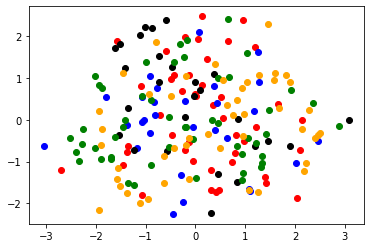

In [ ]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
isomap = Isomap(n_components=2)
Xisomap = isomap.fit_transform(X)
dfs['isomap_0'], dfs['isomap_1'] = Xisomap[:, 0], Xisomap[:, 1]
plt.scatter(dfs.loc[dfs['medoid_cluster'] == 0, 'isomap_0'], dfs.loc[dfs['medoid_cluster'] == 0, 'isomap_1'], color='red')
plt.scatter(dfs.loc[dfs['medoid_cluster'] == 1, 'isomap_0'], dfs.loc[dfs['medoid_cluster'] == 1, 'isomap_1'], color='blue')
plt.scatter(dfs.loc[dfs['medoid_cluster'] == 2, 'isomap_0'], dfs.loc[dfs['medoid_cluster'] == 2, 'isomap_1'], color='black')
plt.scatter(dfs.loc[dfs['medoid_cluster'] == 3, 'isomap_0'], dfs.loc[dfs['medoid_cluster'] == 3, 'isomap_1'], color='green')
plt.scatter(dfs.loc[dfs['medoid_cluster'] == 4, 'isomap_0'], dfs.loc[dfs['medoid_cluster'] == 4, 'isomap_1'], color='orange')
plt.show()

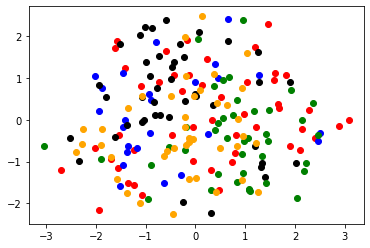

In [ ]:
##TODO similarly, visualize the k-means results
plt.scatter(dfs.loc[dfs['mean_cluster'] == 0, 'isomap_0'], dfs.loc[dfs['mean_cluster'] == 0, 'isomap_1'], color='red')
plt.scatter(dfs.loc[dfs['mean_cluster'] == 1, 'isomap_0'], dfs.loc[dfs['mean_cluster'] == 1, 'isomap_1'], color='blue')
plt.scatter(dfs.loc[dfs['mean_cluster'] == 2, 'isomap_0'], dfs.loc[dfs['mean_cluster'] == 2, 'isomap_1'], color='black')
plt.scatter(dfs.loc[dfs['mean_cluster'] == 3, 'isomap_0'], dfs.loc[dfs['mean_cluster'] == 3, 'isomap_1'], color='green')
plt.scatter(dfs.loc[dfs['mean_cluster'] == 4, 'isomap_0'], dfs.loc[dfs['mean_cluster'] == 4, 'isomap_1'], color='orange')
plt.show()

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies
from gensim import corpora
dictionary = corpora.Dictionary(dfs['tokens'])
print (len(dictionary))
##TODO create the doc_term_matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dfs['tokens']]

2353


In [ ]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [ ]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score
mallet_path = 'mallet-2.0.8/bin/mallet'

scores = []
for num_topics in [5, 10, 15]:
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=dfs['tokens'], corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    scores.append((num_topics, coherence.get_coherence()))
df_topic = pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])
df_topic.head()

,Number of Topics,Coherence Scores
0,5,0.501988
1,10,0.531969
2,15,0.584163


In [ ]:
opt_topics = int(df_topic.iloc[df_topic['Coherence Scores'].idxmax()]['Number of Topics'])
print('The optimal number of topics is: %s' %opt_topics)

The optimal number of topics is: 15


In [ ]:
#!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers
##TODO using LDAvis visualize the topics using the optimal number of topics
lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=opt_topics, id2word=dictionary)
lda_vis = wrappers.ldamallet.malletmodel2ldamodel(lda)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_vis, doc_term_matrix, dictionary)

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.000312 -0.000577       1        1  7.181880
2      0.000506  0.000268       2        1  6.975514
5      0.000492  0.000549       3        1  6.855952
13    -0.000123 -0.000640       4        1  6.765498
0      0.000215  0.000279       5        1  6.759717
11    -0.000458  0.000259       6        1  6.685856
3     -0.000510 -0.000078       7        1  6.637048
9      0.000175  0.000634       8        1  6.594589
7     -0.000054  0.000583       9        1  6.568249
14     0.000302  0.000170      10        1  6.549440
4     -0.000755 -0.000241      11        1  6.547536
10     0.000528 -0.000870      12        1  6.537307
12     0.000051 -0.000222      13        1  6.516833
1     -0.000927  0.000086      14        1  6.468201
8      0.000245 -0.000202      15        1  6.356377, topic_info=            Term      Freq     Total Category  logprob  loglift
385         tune  2.000000  2.000000  Default  30.0000  30.0000
886   collarbone  2.000000  2.000000  Default  29.0000  29.0000
667          day  1.000000  1.000000  Default  28.0000  28.0000
1688     network  2.000000  2.000000  Default  27.0000  27.0000
1355      takbai  2.000000  2.000000  Default  26.0000  26.0000
...          ...       ...       ...      ...      ...      ...
1376        gene  0.159252  2.126726  Topic15  -7.5730   0.1639
389          amp  0.158042  2.119818  Topic15  -7.5807   0.1595
793       lukoil  0.158131  2.131100  Topic15  -7.5801   0.1547
1879         maj  0.157549  2.111078  Topic15  -7.5838   0.1605
1283      defend  0.157425  2.184465  Topic15  -7.5846   0.1255

[637 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 6, 14, 1, 12, 4, 10, 8, 15, 5, 11, 13, 2, 9])